# Testing Performance against Environmental Conditions

## Dataset Loading

In [1]:
from hybrid_dataset import load_aug_dataset_subject
from tqdm import tqdm
import numpy as np
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, '\n')

RAW_PATH = os.path.relpath("../../Soli/soli_realsense/data")
num_subjects = 21

torch.cuda.empty_cache()
train, test, test_idx, test_exp = load_aug_dataset_subject(RAW_PATH, num_subjects, device=device)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '1', 'cudnn_conv1d_pad_to_nc1d': '0', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo',

## Model Loading

In [79]:
from neural_nets import MMFace, concatenate, add, hadamard_product, pairwise_dot_mean, pairwise_dot_max, pairwise_dot_flatten, multihead_attention, radar, rgb
from utils import load_model

del model
model = MMFace(num_subjects, fuse=rgb).to(device)

model_name = f"mmFace-rgb.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9))

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]}\n\tValidation Accuracy: {val_acc}")

mmFace-rgb.pt
	Epoch: 5
	Loss: 0.0207
	Train Accuracy: (99.91497449234771, 100.0)
	Validation Accuracy: []


## Zero-Shot Testing

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import json

def get_activation(activation, name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def cos_sim(x, Y):
    return x @ Y.T / (np.linalg.norm(x)*np.linalg.norm(Y, axis=1))

def search_flatten(reference_embs, unseen_embeddings, labels1, labels2, t=0.5, max_t=0.999):
    preds = []
    for emb in unseen_embeddings:
        scores = cos_sim(emb, reference_embs)
        scores = np.clip(scores, 0., 1.)
        # Ensure scores >= max threshold are discarded
        l1 = np.array(labels1)[scores < max_t]
        l2 = np.array(labels2)[scores < max_t]
        scores = scores[scores < max_t]

        idx = np.argmax(scores)
        if scores[idx] > t:
            preds.append((l1[idx], l2[idx]))
        else:
            preds.append((None, None))
    
    return preds

def evaluate(true_labels, pred_labels, labels):
    coverage = np.mean([n != -1 for n in pred_labels]) * 100.
    is_corrects = [t == p for t, p in zip(true_labels, pred_labels) if p != -1]
    if not is_corrects:
        is_corrects.append(False)

    accuracy = np.mean(is_corrects) * 100.

    cfm = confusion_matrix(true_labels, pred_labels, labels=labels)

    return accuracy, coverage, cfm

def log_results(filename, results):
    with open(filename, 'r') as f:
        evaluation = json.load(f)
        
    evaluation[model_name] = results
    
    with open(filename, 'w') as g:
        json.dump(evaluation, g)

def sim_scores(reference_emb, unseen_embeddings):
    max_scores = []
    for emb in unseen_embeddings:
        score = cos_sim(emb, reference_emb)
        max_scores.append(score[0])
    
    return max_scores

def OVR_ROC_macro_average(reference_subs, reference_embs, unseen_embeddings, true_labels):
    fpr, tpr, roc_auc = {}, {}, {}

    fpr_grid = np.linspace(0., 1., 1000)
    mean_tpr = np.zeros_like(fpr_grid)
    
    for i, r in enumerate(reference_subs):
        scores = sim_scores(reference_embs[i, None], unseen_embeddings)
        true_onehot_r = [1 if l == r and l != -1 else 0 for l in true_labels]
        fpr[i], tpr[i], _ = roc_curve(true_onehot_r, scores)
        roc_auc[i] = auc(fpr[i], tpr[i])

        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])
    
    mean_tpr /= len(reference_subs)
    mean_roc_auc = auc(fpr_grid, mean_tpr)

    fpr["macro"], tpr["macro"], roc_auc["macro"] = fpr_grid, mean_tpr, mean_roc_auc

    return fpr, tpr, roc_auc

### Dim Lighting Condition

In [74]:
from hybrid_dataset import get_ard_aug, get_rgb_emb_aug

test_dlc = [data for i, data in enumerate(test) if test_exp[i] in range(10, 15)]
test_subjects = [i if i < num_subjects else int(f"9{(i-num_subjects)}") for i in test_idx]
print(test_subjects)

# Gather raw reference data (Taking frame 7 of ARD and RGB embedding of 0°,DLC,NO)
f = 7
exp = 10
print(f"Frame: {f} | Experiment: {exp}")
references_raw = [(torch.tensor(get_ard_aug(RAW_PATH, sub, exp, 250, "none")[f], device=device).unsqueeze(0), 
                   torch.tensor(get_rgb_emb_aug(RAW_PATH, sub, exp, "none", set())[f], device=device, dtype=torch.float32).unsqueeze(0)) for sub in tqdm(test_subjects)]

model.eval()
activation = {}
# Hook to get last layer feature embeddings
model.fc_hybrid1.register_forward_hook(get_activation(activation, "fc_hybrid1"))

reference_embs = np.zeros((len(references_raw), 64))
unseen_embeddings, true_labels_s, true_labels_l = [], [], []
with torch.no_grad():
    for i, raw_inputs in enumerate(references_raw):
        _ = model(*raw_inputs)
        reference_embs[i] = activation["fc_hybrid1"].detach().cpu().numpy()

    for radar, rgb_emb, subjects, liveness in test_dlc:
        _ = model(radar, rgb_emb)
        unseen_embeddings.append(activation["fc_hybrid1"].detach().cpu().numpy())
        true_labels_s.append(subjects.detach().cpu().numpy())
        true_labels_l.append(liveness.detach().cpu().numpy())


ref_labels_s = [idx if idx < num_subjects else idx-num_subjects for idx in test_idx]
ref_labels_l = [1 if idx < num_subjects else 0 for idx in test_idx]

unseen_embeddings = np.concatenate(unseen_embeddings)
true_labels_s = np.concatenate(true_labels_s, dtype=np.int32)
true_labels_l = np.concatenate(true_labels_l, dtype=np.int32)

[20, 2, 5, 15, 920, 92, 95, 915]
Frame: 7 | Experiment: 10


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


In [75]:
preds_s, preds_l = list(zip(*search_flatten(reference_embs, unseen_embeddings, ref_labels_s, ref_labels_l, t=0.5)))

test_classes_s = sorted(ref_labels_s[:len(ref_labels_s)//2]) + [-1]
test_classes_l = [0, 1, -1]

preds_s_norm = np.array(preds_s)
preds_s_norm[np.where(preds_s_norm == None)[0]] = -1
preds_s_norm = np.array(preds_s_norm, dtype=np.int32)

preds_l_norm = np.array(preds_l)
preds_l_norm[np.where(preds_l_norm == None)[0]] = -1
preds_l_norm = np.array(preds_l_norm, dtype=np.int32)

acc_subject, cov_subject, cfm_subject = evaluate(true_labels_s, preds_s_norm, test_classes_s)
acc_liveness, cov_liveness, cfm_liveness = evaluate(true_labels_l, preds_l_norm, test_classes_l)

print(f"Zero-shot Test ({model_name}):")
print(f"\tSUBJECT - Accuracy: {acc_subject:.4f}% | Coverage: {cov_subject:.4f}%")
print(f"\tLIVENESS - Accuracy: {acc_liveness:.4f}% | Coverage: {cov_liveness:.4f}%")

Zero-shot Test (mmFace-rgb.pt):
	SUBJECT - Accuracy: 88.5534% | Coverage: 92.7083%
	LIVENESS - Accuracy: 75.4916% | Coverage: 92.7083%


#### F-Measure

In [ ]:
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

beta = 0.5
subject_names = test_classes_s[:-1]+["NONE"]
liveness_names = ["Fake", "Real", "NONE"]

df_fb_s = pd.DataFrame(fbeta_score(true_labels_s, preds_s_norm, beta=beta, labels=test_classes_s, average=None), index=subject_names)
plt.figure(figsize=(2, 5))
heatmap_fb_s = sn.heatmap(df_fb_s, annot=True)
heatmap_fb_s.set(xlabel="F_{0.5} Score", title="F_{0.5} Scores")

df_fb_l = pd.DataFrame(fbeta_score(true_labels_l, preds_l_norm, beta=beta, labels=test_classes_l, average=None), index=liveness_names)
plt.figure(figsize=(2, 3))
heatmap_fb_l = sn.heatmap(df_fb_l, annot=True)
heatmap_fb_l.set(xlabel="F_{0.5} Score", title="F_{0.5} Scores")

In [77]:
from sklearn.metrics import f1_score, fbeta_score


micro_f1_s = f1_score(true_labels_s, preds_s_norm, labels=test_classes_s, average="micro")
micro_f1_l = f1_score(true_labels_l, preds_l_norm, labels=test_classes_l, average="micro")
print(f"Micro-Averaged F1 Score (Subject): {micro_f1_s:.4f}")
print(f"Micro-Averaged F1 Score (Liveness): {micro_f1_l:.4f}")

beta = 0.5
weighted_fb_s = fbeta_score(true_labels_s, preds_s_norm, beta=beta, labels=test_classes_s, average="weighted")
weighted_fb_l = fbeta_score(true_labels_l, preds_l_norm, beta=beta, labels=test_classes_l, average="weighted")
print(f"Weighted-Averaged F_{{{beta}}} Score (Subject): {weighted_fb_s:.4f}")
print(f"Weighted-Averaged F_{{{beta}}} Score (Liveness): {weighted_fb_l:.4f}")

Micro-Averaged F1 Score (Subject): 0.8210
Micro-Averaged F1 Score (Liveness): 0.6999
Weighted-Averaged F_{0.5} Score (Subject): 0.8716
Weighted-Averaged F_{0.5} Score (Liveness): 0.7498


#### ROC Curves and AUC

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours

true_labels_combined = [s if true_labels_l[i] else s+num_subjects for i, s in enumerate(true_labels_s)]
fpr, tpr, roc_auc = OVR_ROC_macro_average(test_idx, reference_embs, unseen_embeddings, true_labels_combined)

fig, ax = plt.subplots(figsize=(7, 6), dpi=500)
ax.plot(fpr["macro"], tpr["macro"], label=f"Macro-Average (AUC = {roc_auc['macro']:.2f})", color="navy", linestyle=":", linewidth=3)

roc_colours = list(mcolours.TABLEAU_COLORS.values())
for i, r in enumerate(ref_labels_s):
    ax.plot(fpr[i], tpr[i], label=f"Subject {r}-{'Live' if i < len(ref_labels_s)//2 else 'Fake'} vs. rest (AUC = {roc_auc[i]:.2f})", color=roc_colours[i])

ax.plot([0, 1], [0, 1], label="Chance Level (AUC = 0.5)", color="black", linestyle="--", linewidth=2)
ax.set(xlabel="False Positive Rate (FPR)", ylabel="True Positive Rate (TPR)", title=f"OvR ROC Curves for all 8 Reference Subjects DLC ({model_name})")
ax.legend(fontsize="9")
print(f"Macro-Averaged AUC: {roc_auc['macro']:.4f}")

#### t-SNE Visualisations

In [79]:
from sklearn.manifold import TSNE

# Perplexities between 5-10 produce closer, circular clusters | Higher perplexities, distinct islands
tsne = TSNE(n_components=2, perplexity=45)
X_tsne = tsne.fit_transform(unseen_embeddings)

print(f"KL Divergence ({model_name}): {tsne.kl_divergence_:.4f}")

KL Divergence (mmFace-rgb.pt): 0.1470


In [ ]:
import matplotlib.pyplot as plt

h = len(ref_labels_s)//2
true_labels_norm = [ref_labels_s.index(true_labels_s[i]) + (0 if true_labels_l[i] else h) for i in range(len(true_labels_s))]

shades = [
    "#1f78b4",  # Blue
    "#ff7f00",  # Orange
    "#33a02c",  # Green
    "#e31a1c"   # Red
]

lighter_shades = [
    "#6baed6",  # Lighter shade of Blue
    "#ffbb78",  # Lighter shade of Orange
    "#a6dba0",  # Lighter shade of Green
    "#fb9a99"   # Lighter shade of Red
]

colours = np.array([shades[t] if true_labels_l[i] else lighter_shades[t % h] for i, t in enumerate(true_labels_norm)])

fig, ax = plt.subplots(figsize=(7, 6), dpi=500)
# ax = fig.add_subplot(projection="3d")
for i, colour in enumerate(shades + lighter_shades):
    indices = np.where(colours == colour)
    l = indices[0][0]
    
    ax.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=colour, label=f"Subject {true_labels_s[l]}-{'Live' if true_labels_l[l] else 'Fake'}", alpha=0.3
        )

plt.title(f"t-SNE Visualisation DLC ({model_name})")
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
legend = plt.legend(fontsize=6, loc="lower right")
for lh in legend.legend_handles:
    lh.set_alpha(1)
plt.show()

### Occlusion Scenario

In [80]:
from hybrid_dataset import get_ard_aug, get_rgb_emb_aug

test_o = [data for i, data in enumerate(test) if test_exp[i] in range(10, 15)]
test_subjects = [i if i < num_subjects else int(f"9{(i-num_subjects)}") for i in test_idx]
print(test_subjects)

# Gather raw reference data (Taking frame 7 of ARD and RGB embedding of 0°,RLC,O)
f = 7
exp = 5
print(f"Frame: {f} | Experiment: {exp}")
references_raw = [(torch.tensor(get_ard_aug(RAW_PATH, sub, exp, 250, "none")[f], device=device).unsqueeze(0), 
                   torch.tensor(get_rgb_emb_aug(RAW_PATH, sub, exp, "none", set())[f], device=device, dtype=torch.float32).unsqueeze(0)) for sub in tqdm(test_subjects)]

model.eval()
activation = {}
# Hook to get last layer feature embeddings
model.fc_hybrid1.register_forward_hook(get_activation(activation, "fc_hybrid1"))

reference_embs = np.zeros((len(references_raw), 64))
unseen_embeddings, true_labels_s, true_labels_l = [], [], []
with torch.no_grad():
    for i, raw_inputs in enumerate(references_raw):
        _ = model(*raw_inputs)
        reference_embs[i] = activation["fc_hybrid1"].detach().cpu().numpy()

    for radar, rgb_emb, subjects, liveness in test_o:
        _ = model(radar, rgb_emb)
        unseen_embeddings.append(activation["fc_hybrid1"].detach().cpu().numpy())
        true_labels_s.append(subjects.detach().cpu().numpy())
        true_labels_l.append(liveness.detach().cpu().numpy())


ref_labels_s = [idx if idx < num_subjects else idx-num_subjects for idx in test_idx]
ref_labels_l = [1 if idx < num_subjects else 0 for idx in test_idx]

unseen_embeddings = np.concatenate(unseen_embeddings)
true_labels_s = np.concatenate(true_labels_s, dtype=np.int32)
true_labels_l = np.concatenate(true_labels_l, dtype=np.int32)

[20, 2, 5, 15, 920, 92, 95, 915]
Frame: 7 | Experiment: 5


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


In [81]:
preds_s, preds_l = list(zip(*search_flatten(reference_embs, unseen_embeddings, ref_labels_s, ref_labels_l, t=0.5)))

test_classes_s = sorted(ref_labels_s[:len(ref_labels_s)//2]) + [-1]
test_classes_l = [0, 1, -1]

preds_s_norm = np.array(preds_s)
preds_s_norm[np.where(preds_s_norm == None)[0]] = -1
preds_s_norm = np.array(preds_s_norm, dtype=np.int32)

preds_l_norm = np.array(preds_l)
preds_l_norm[np.where(preds_l_norm == None)[0]] = -1
preds_l_norm = np.array(preds_l_norm, dtype=np.int32)

acc_subject, cov_subject, cfm_subject = evaluate(true_labels_s, preds_s_norm, test_classes_s)
acc_liveness, cov_liveness, cfm_liveness = evaluate(true_labels_l, preds_l_norm, test_classes_l)

print(f"Zero-shot Test ({model_name}):")
print(f"\tSUBJECT - Accuracy: {acc_subject:.4f}% | Coverage: {cov_subject:.4f}%")
print(f"\tLIVENESS - Accuracy: {acc_liveness:.4f}% | Coverage: {cov_liveness:.4f}%")

Zero-shot Test (mmFace-rgb.pt):
	SUBJECT - Accuracy: 87.8592% | Coverage: 90.6250%
	LIVENESS - Accuracy: 69.1810% | Coverage: 90.6250%


#### F-Measure

[Text(0.5, 3.722222222222216, 'F_{0.5} Score'),
 Text(0.5, 1.0, 'F_{0.5} Scores')]

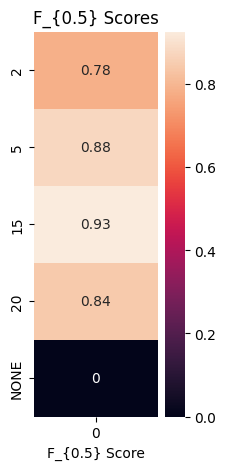

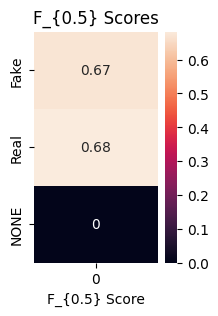

In [82]:
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

beta = 0.5
subject_names = test_classes_s[:-1]+["NONE"]
liveness_names = ["Fake", "Real", "NONE"]

df_fb_s = pd.DataFrame(fbeta_score(true_labels_s, preds_s_norm, beta=beta, labels=test_classes_s, average=None), index=subject_names)
plt.figure(figsize=(2, 5))
heatmap_fb_s = sn.heatmap(df_fb_s, annot=True)
heatmap_fb_s.set(xlabel="F_{0.5} Score", title="F_{0.5} Scores")

df_fb_l = pd.DataFrame(fbeta_score(true_labels_l, preds_l_norm, beta=beta, labels=test_classes_l, average=None), index=liveness_names)
plt.figure(figsize=(2, 3))
heatmap_fb_l = sn.heatmap(df_fb_l, annot=True)
heatmap_fb_l.set(xlabel="F_{0.5} Score", title="F_{0.5} Scores")

In [83]:
from sklearn.metrics import f1_score, fbeta_score


micro_f1_s = f1_score(true_labels_s, preds_s_norm, labels=test_classes_s, average="micro")
micro_f1_l = f1_score(true_labels_l, preds_l_norm, labels=test_classes_l, average="micro")
print(f"Micro-Averaged F1 Score (Subject): {micro_f1_s:.4f}")
print(f"Micro-Averaged F1 Score (Liveness): {micro_f1_l:.4f}")

beta = 0.5
weighted_fb_s = fbeta_score(true_labels_s, preds_s_norm, beta=beta, labels=test_classes_s, average="weighted")
weighted_fb_l = fbeta_score(true_labels_l, preds_l_norm, beta=beta, labels=test_classes_l, average="weighted")
print(f"Weighted-Averaged F_{{{beta}}} Score (Subject): {weighted_fb_s:.4f}")
print(f"Weighted-Averaged F_{{{beta}}} Score (Liveness): {weighted_fb_l:.4f}")

Micro-Averaged F1 Score (Subject): 0.7962
Micro-Averaged F1 Score (Liveness): 0.6270
Weighted-Averaged F_{0.5} Score (Subject): 0.8587
Weighted-Averaged F_{0.5} Score (Liveness): 0.6775


#### ROC Curves and AUC

Macro-Averaged AUC: 0.8611


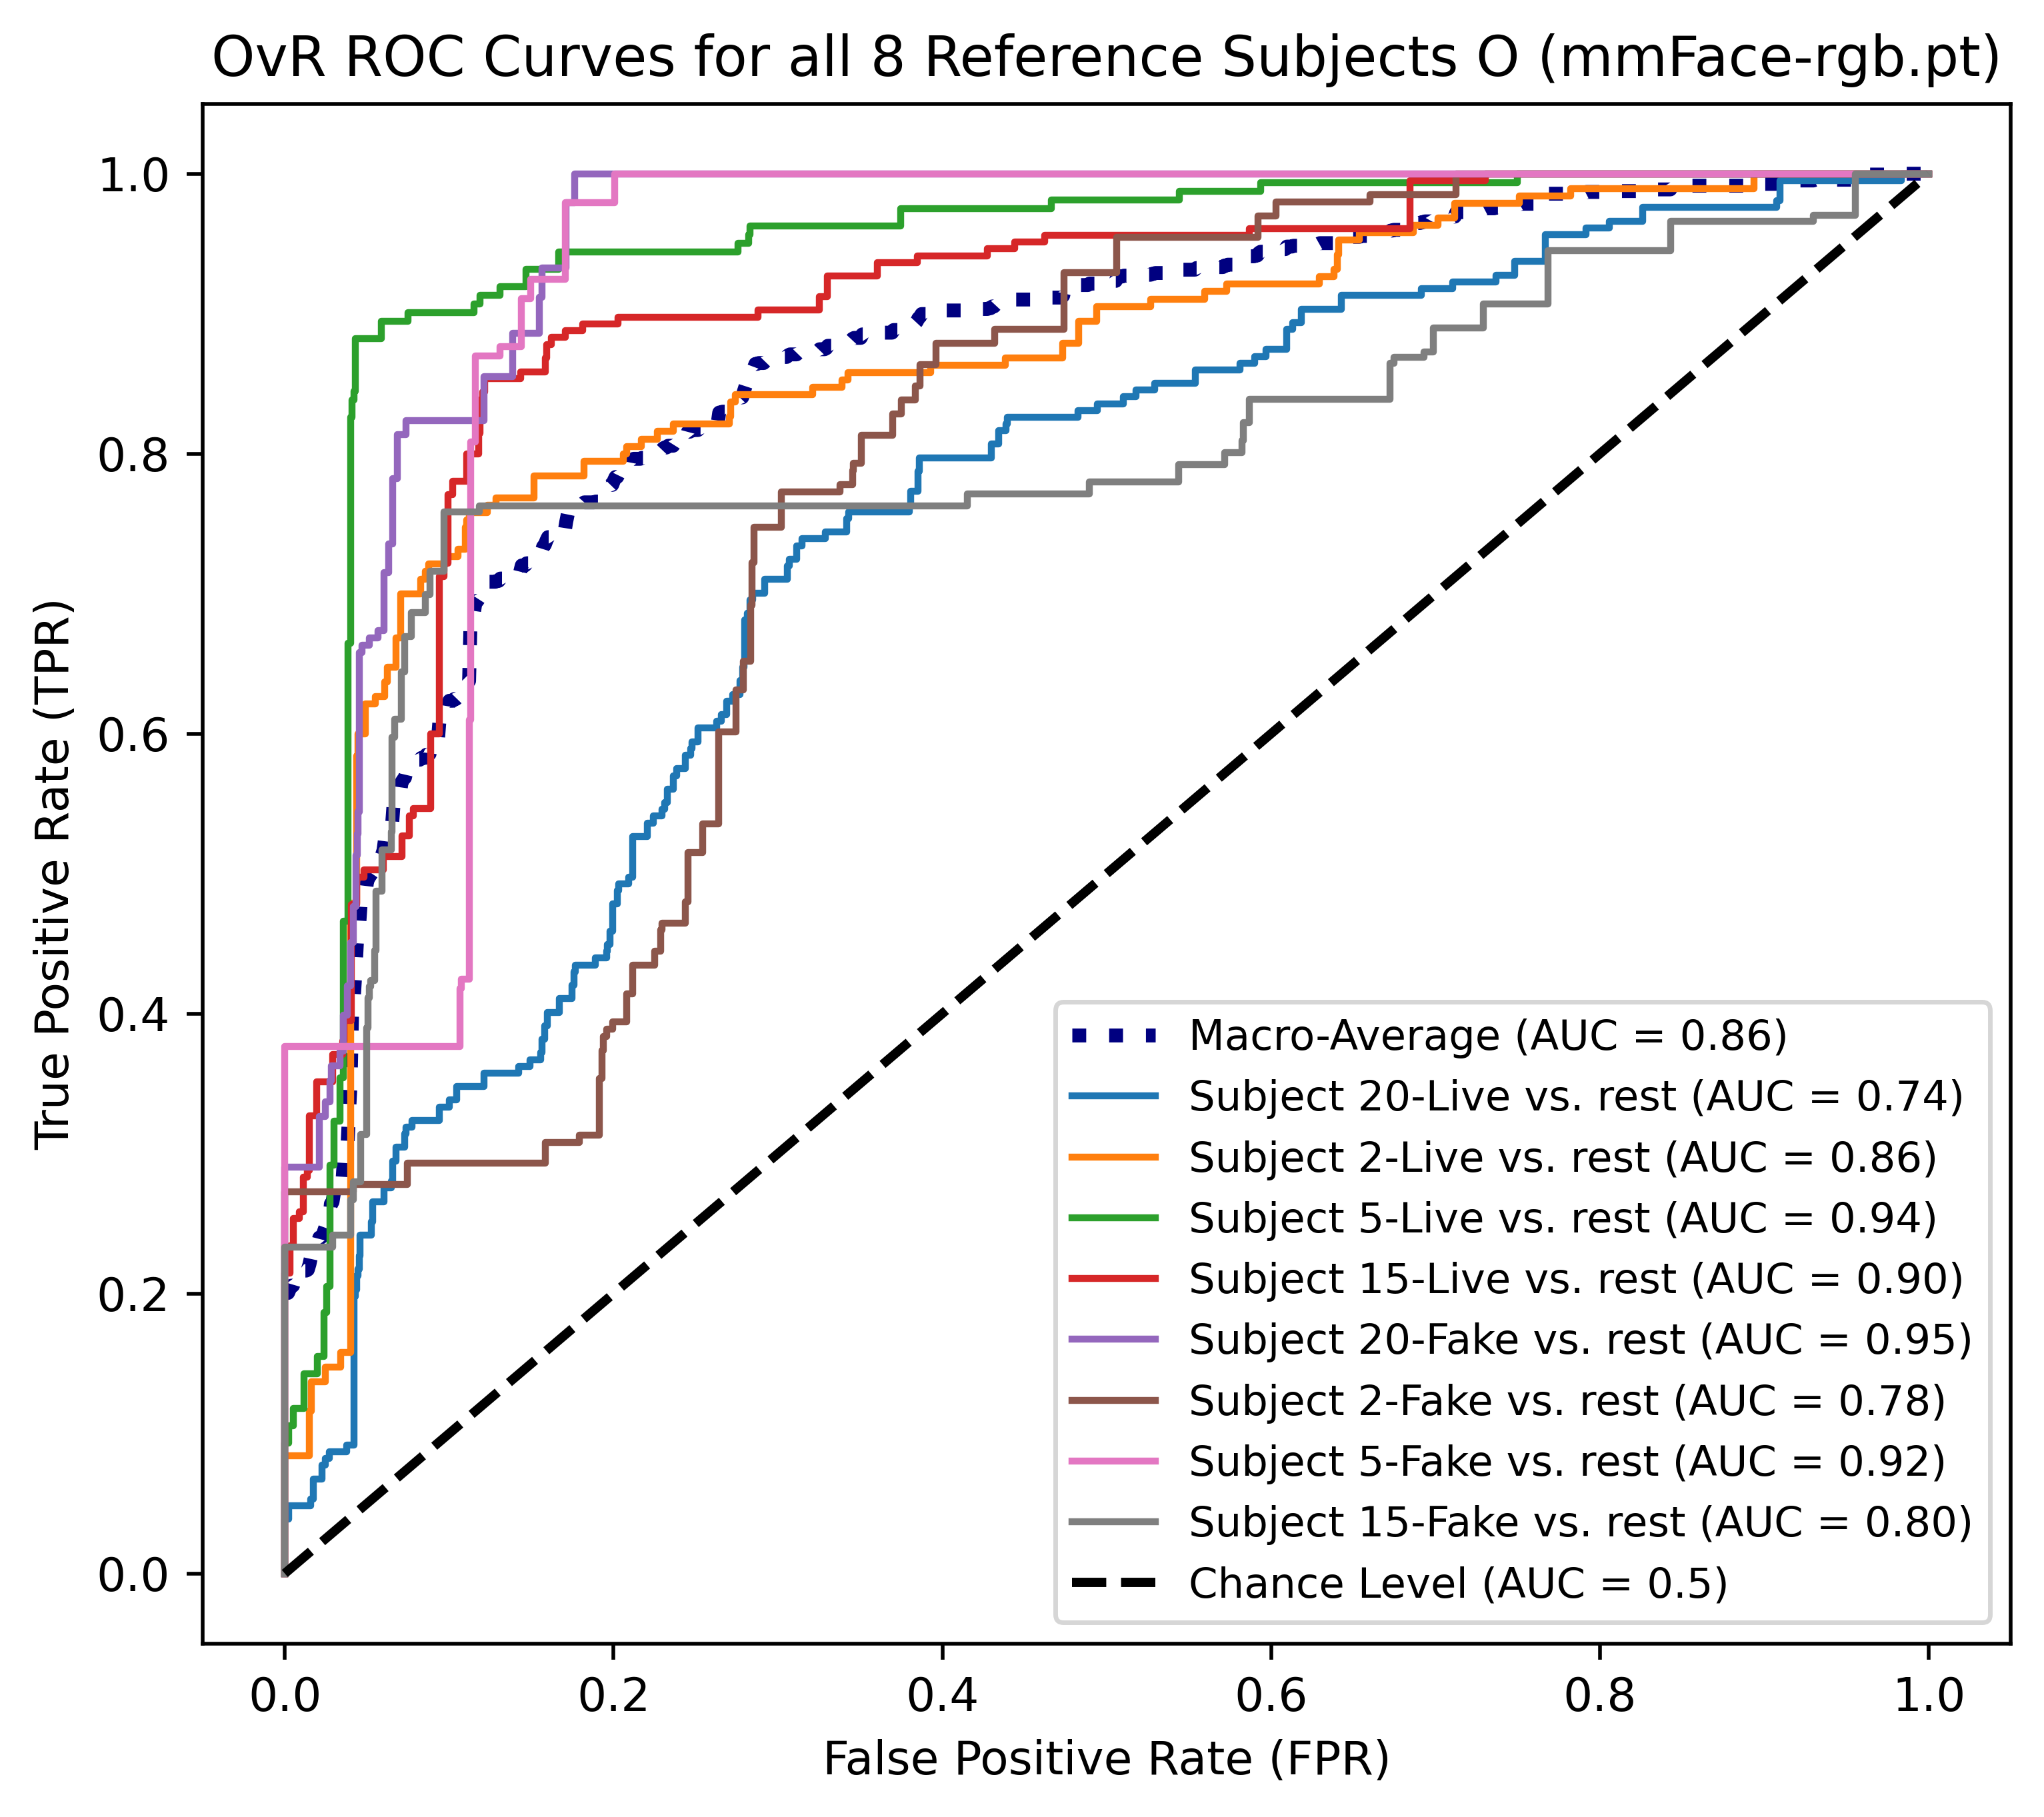

In [84]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours

true_labels_combined = [s if true_labels_l[i] else s+num_subjects for i, s in enumerate(true_labels_s)]
fpr, tpr, roc_auc = OVR_ROC_macro_average(test_idx, reference_embs, unseen_embeddings, true_labels_combined)

fig, ax = plt.subplots(figsize=(7, 6), dpi=500)
ax.plot(fpr["macro"], tpr["macro"], label=f"Macro-Average (AUC = {roc_auc['macro']:.2f})", color="navy", linestyle=":", linewidth=3)

roc_colours = list(mcolours.TABLEAU_COLORS.values())
for i, r in enumerate(ref_labels_s):
    ax.plot(fpr[i], tpr[i], label=f"Subject {r}-{'Live' if i < len(ref_labels_s)//2 else 'Fake'} vs. rest (AUC = {roc_auc[i]:.2f})", color=roc_colours[i])

ax.plot([0, 1], [0, 1], label="Chance Level (AUC = 0.5)", color="black", linestyle="--", linewidth=2)
ax.set(xlabel="False Positive Rate (FPR)", ylabel="True Positive Rate (TPR)", title=f"OvR ROC Curves for all 8 Reference Subjects O ({model_name})")
ax.legend(fontsize="9")
print(f"Macro-Averaged AUC: {roc_auc['macro']:.4f}")

#### t-SNE Visualisations

In [85]:
from sklearn.manifold import TSNE

# Perplexities between 5-10 produce closer, circular clusters | Higher perplexities, distinct islands
tsne = TSNE(n_components=2, perplexity=45)
X_tsne = tsne.fit_transform(unseen_embeddings)

print(f"KL Divergence ({model_name}): {tsne.kl_divergence_:.4f}")

KL Divergence (mmFace-rgb.pt): 0.1487


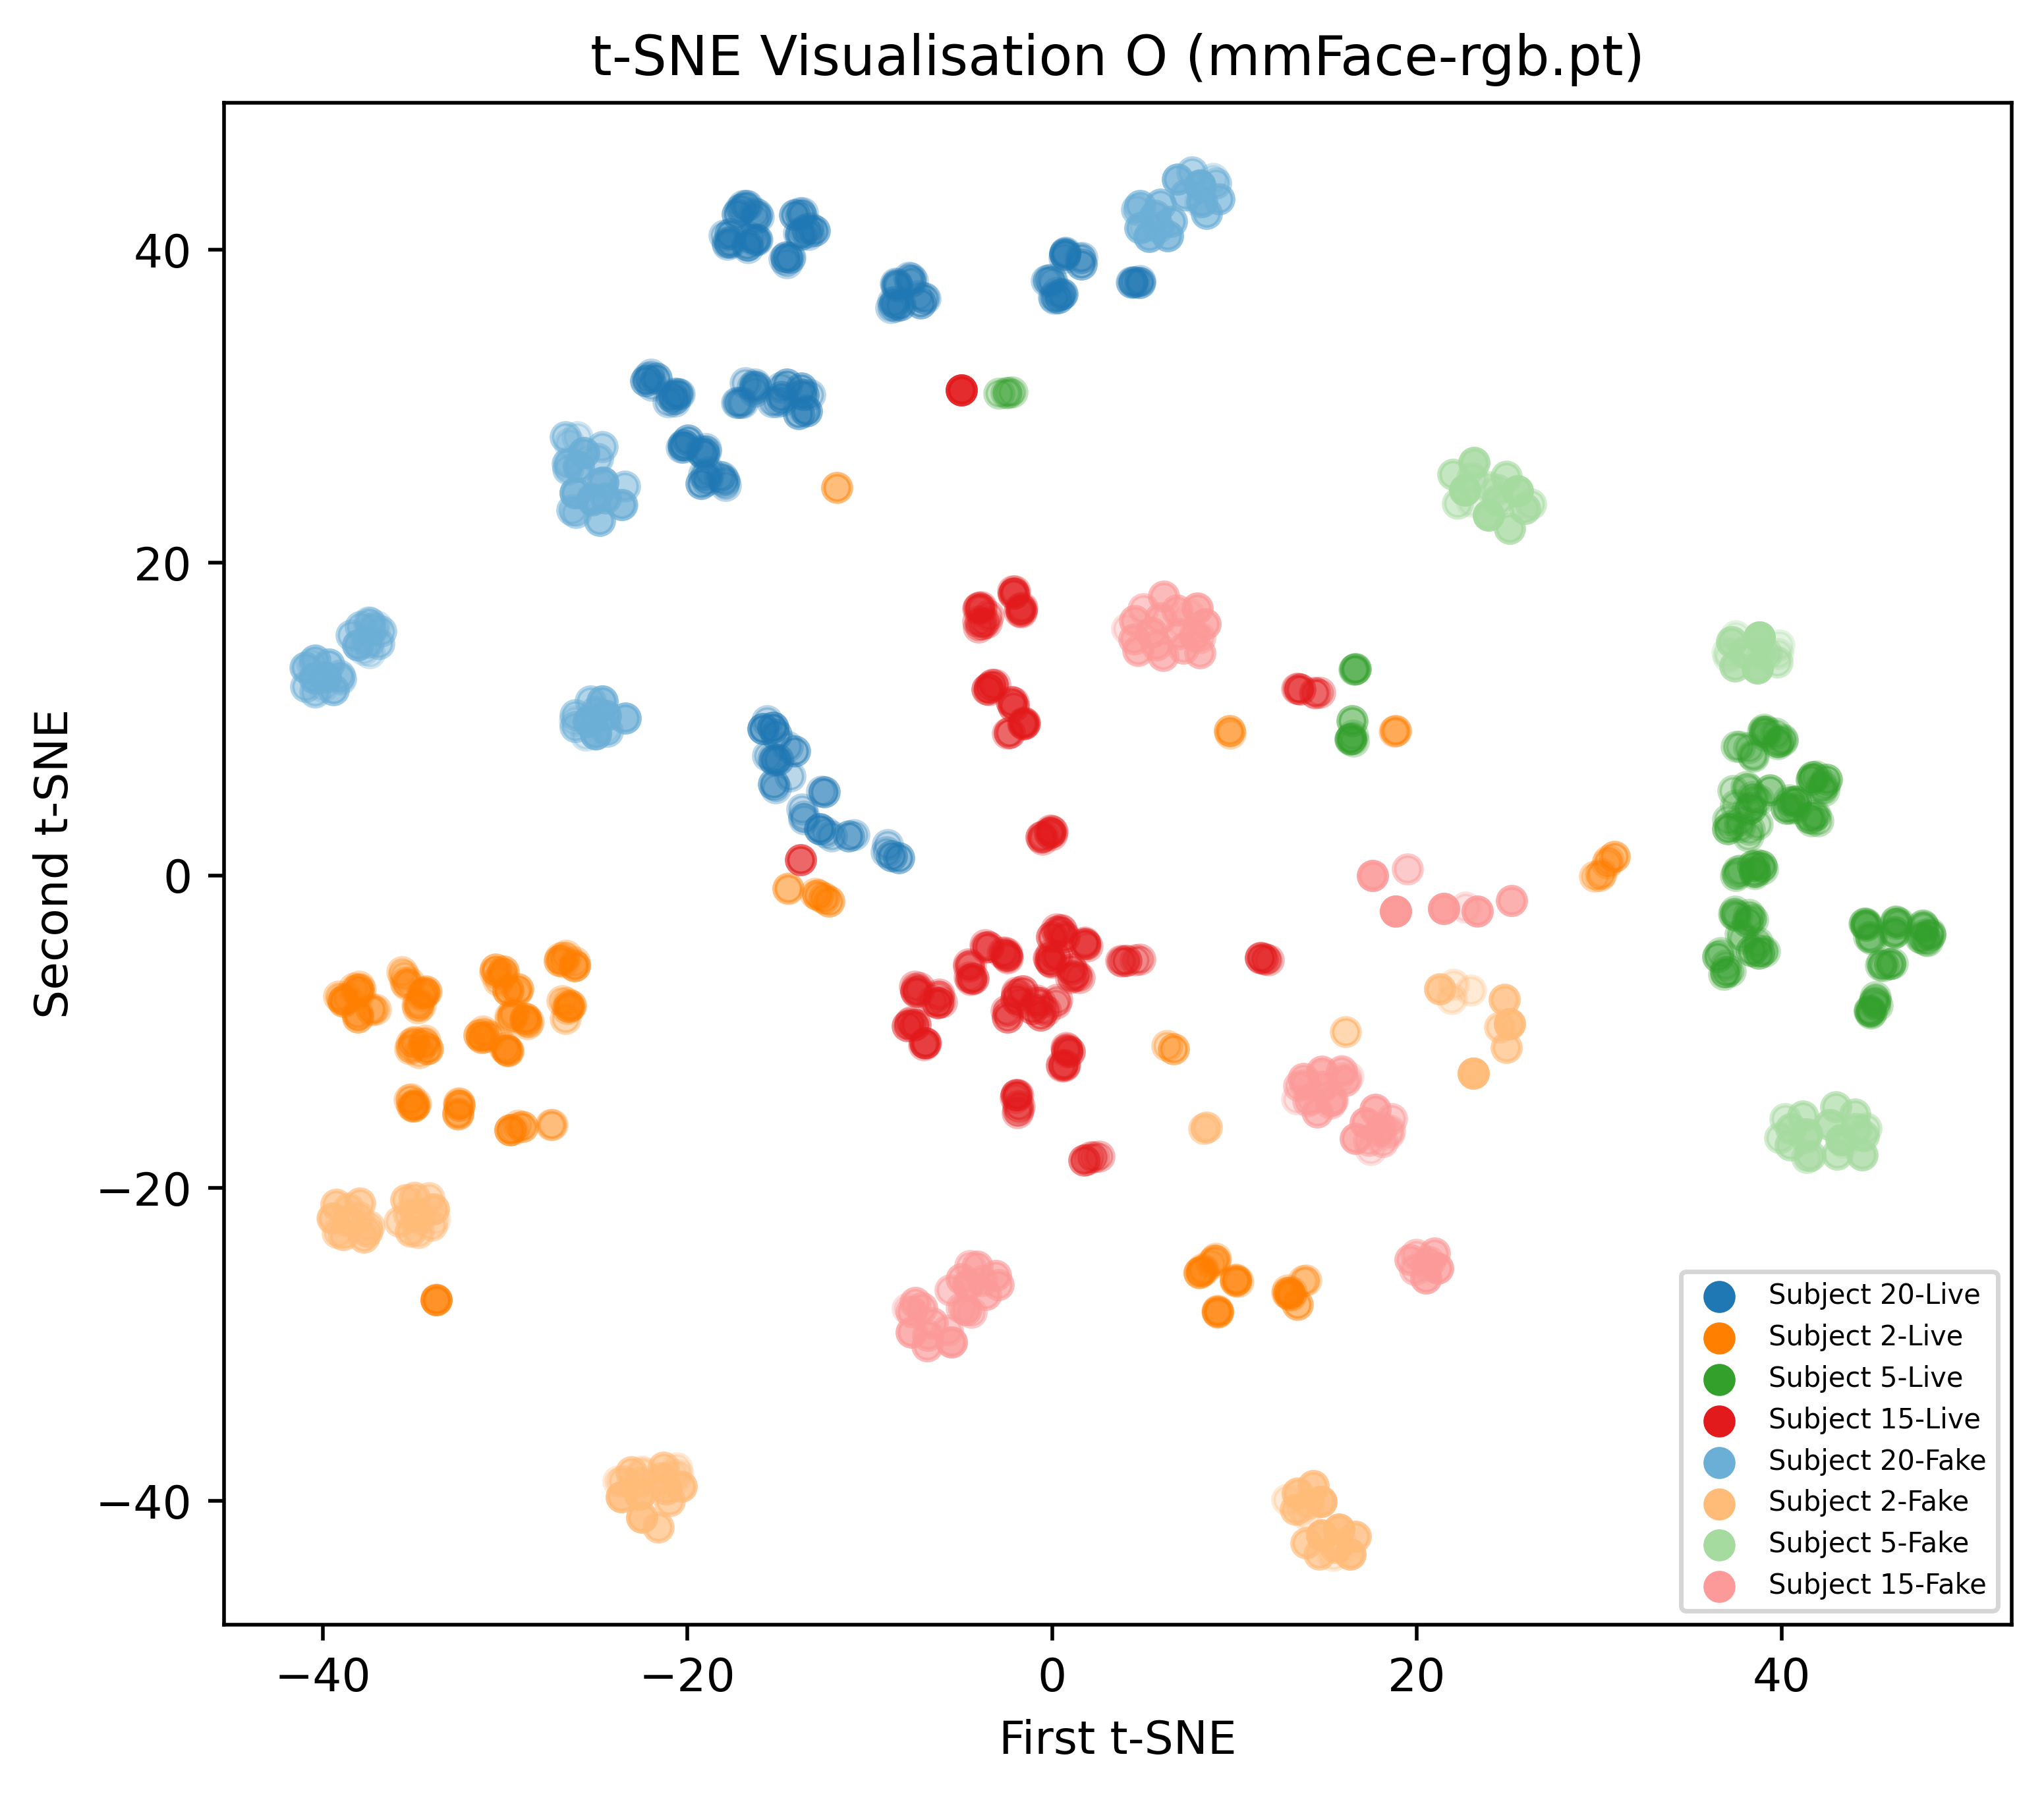

In [86]:
import matplotlib.pyplot as plt

h = len(ref_labels_s)//2
true_labels_norm = [ref_labels_s.index(true_labels_s[i]) + (0 if true_labels_l[i] else h) for i in range(len(true_labels_s))]

shades = [
    "#1f78b4",  # Blue
    "#ff7f00",  # Orange
    "#33a02c",  # Green
    "#e31a1c"   # Red
]

lighter_shades = [
    "#6baed6",  # Lighter shade of Blue
    "#ffbb78",  # Lighter shade of Orange
    "#a6dba0",  # Lighter shade of Green
    "#fb9a99"   # Lighter shade of Red
]

colours = np.array([shades[t] if true_labels_l[i] else lighter_shades[t % h] for i, t in enumerate(true_labels_norm)])

fig, ax = plt.subplots(figsize=(7, 6), dpi=500)
# ax = fig.add_subplot(projection="3d")
for i, colour in enumerate(shades + lighter_shades):
    indices = np.where(colours == colour)
    l = indices[0][0]
    
    ax.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=colour, label=f"Subject {true_labels_s[l]}-{'Live' if true_labels_l[l] else 'Fake'}", alpha=0.3
        )

plt.title(f"t-SNE Visualisation O ({model_name})")
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
legend = plt.legend(fontsize=6, loc="lower right")
for lh in legend.legend_handles:
    lh.set_alpha(1)
plt.show()

## Log Results

In [87]:
results = { "SUBJECT": { 
                "Accuracy": round(acc_subject, 4),
                "Micro-Accuracy": round(micro_f1_s, 4),
                "Weighted-Averaged F-Score": round(weighted_fb_s, 4)
            },
            "LIVENESS": {
                "Accuracy": round(acc_liveness, 4),
                "Micro-Accuracy": round(micro_f1_l, 4),
                "Weighted-Averaged F-Score": round(weighted_fb_l, 4)
            },
            "Coverage": round(cov_subject, 4),
            "Macro-Averaged AUC": round(roc_auc["macro"], 4),
            "KL Divergence": round(tsne.kl_divergence_, 4)
}

# log_results("results_dlc.json", results)
log_results("results_o.json", results)